<a href="https://colab.research.google.com/github/paishowstopper/TSAI/blob/main/EVA5B2_Session3_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision # provide access to datasets, models, transforms, utils, etc
import torchvision.transforms as transforms

In [2]:
train_set = torchvision.datasets.EMNIST(
    root = './data',
    split = 'byclass',
    train = True,
    download = True,
    transform = transforms.Compose([
        # map values from [0, 255] to [0, 1]   
        # by converting array to tensor, and then dividing by 255                         
        transforms.ToTensor() 
    ]))

test_set = torchvision.datasets.EMNIST(
    root = './data',
    split = 'byclass',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()
    ]))

Extracting ./data/EMNIST/raw/emnist.zip to ./data/EMNIST/raw
Processing byclass


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Processing bymerge
Processing balanced
Processing letters
Processing digits
Processing mnist
Done!


In [3]:
import numpy as np
import matplotlib.pyplot as plt

torch.set_printoptions(linewidth=120)

label: 35


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


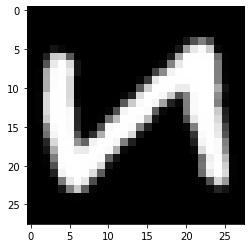

In [9]:
len(train_set)

train_set.train_labels.min(), train_set.train_labels.max()

train_set.train_labels.bincount()

sample = next(iter(train_set))
len(sample), type(sample)

image, label = sample
image.shape, label

plt.imshow(image.squeeze(), cmap='gray')
print('label:', label)

In [10]:
torch.manual_seed(1) # for reproducibility
BATCH_SIZE = 128

use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# shuffle to 1) prevent model from learning image orders, and
#            2) assure equal distribution of classes
train_loader = torch.utils.data.DataLoader(
    train_set, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    **kwargs) 

test_loader = torch.utils.data.DataLoader(
    test_set, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    **kwargs)

labels: tensor([37, 28, 34, 12,  3, 24, 55, 51,  4,  5, 41, 30,  3,  7, 23, 35, 40,  2,  5,  6, 32, 36, 43,  3,  6, 39,  9,  1,
         6, 28, 43, 50,  5,  5,  2,  2,  2,  3,  0, 18,  2,  2, 58,  7,  5, 55,  1, 13, 57,  1, 18, 26,  7, 19,  3, 44,
         7, 40,  5,  7, 49,  8,  1,  9,  0,  9, 60, 13,  7, 49,  7,  5,  9,  2, 18, 24,  7,  1, 40,  6, 47, 55,  0,  5,
        38,  0, 28,  0,  2,  6, 24, 60, 50,  6, 47, 22,  3, 40, 37,  5,  9, 45, 28,  3, 35,  9,  2, 32,  0, 47, 29, 39,
         1,  9, 25, 28, 32,  6, 18, 29, 30,  2, 22, 28, 24, 23, 40, 31])


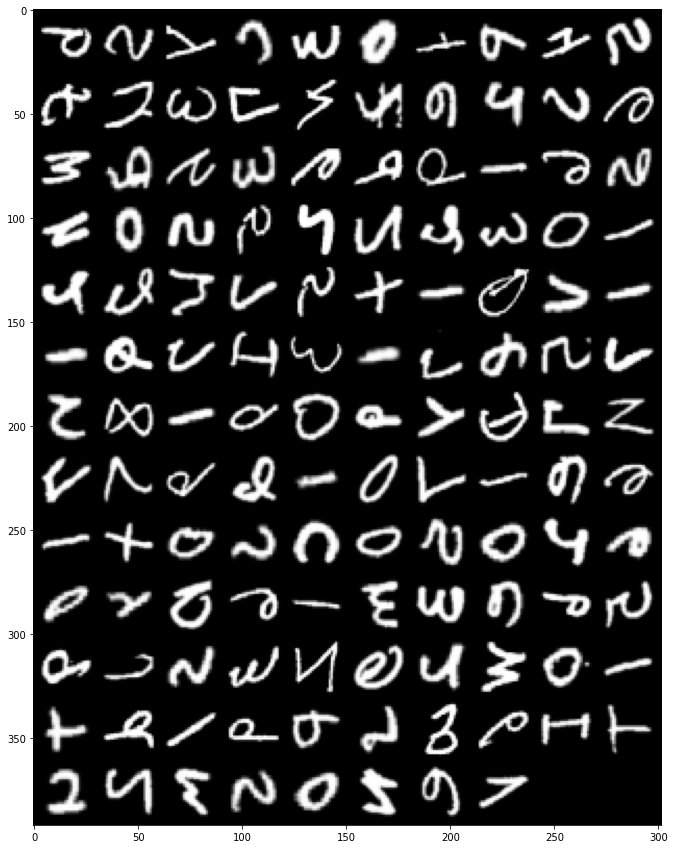

In [12]:
batch = next(iter(train_loader))

len(batch), type(batch)

images, labels = batch

grid = torchvision.utils.make_grid(images, nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))
print('labels:', labels)

In [16]:
import torch.nn as nn
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=20, out_channels=20, kernel_size=3)
        self.conv5 = nn.Conv2d(in_channels=20, out_channels=30, kernel_size=3)
        self.conv6 = nn.Conv2d(in_channels=30, out_channels=62, kernel_size=3)

    def forward(self, t):

        # (1) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)

        # (2) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)

        # (1) max pool layer
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # (3) hidden conv layer
        t = self.conv3(t)
        t = F.relu(t)

        # (4) hidden conv layer
        t = self.conv4(t)
        t = F.relu(t)

        # (2) max pool layer
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # (5) hidden conv layer
        t = self.conv5(t)
        t = F.relu(t)

        # (6) hidden conv layer
        t = self.conv6(t)

        # (1) output layer
        t = F.softmax(t.view(-1, 62), dim=1)

        return t

In [17]:
!pip install torchsummary
from torchsummary import summary

device = torch.device("cuda" if use_cuda else "cpu")
model = Network().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]             100
            Conv2d-2           [-1, 10, 28, 28]             910
            Conv2d-3           [-1, 20, 12, 12]           1,820
            Conv2d-4           [-1, 20, 10, 10]           3,620
            Conv2d-5             [-1, 30, 3, 3]           5,430
            Conv2d-6             [-1, 62, 1, 1]          16,802
Total params: 28,682
Trainable params: 28,682
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.16
Params size (MB): 0.11
Estimated Total Size (MB): 0.27
----------------------------------------------------------------


In [18]:
def train(model: 'neural network', 
          device: 'CPU or GPU', 
          train_loader: 'training batch', 
          optimizer: 'weight-optimizing algorithm', 
          epochs: 'how many cycles of consuming the entire batches'):
    
    # set model to train mode, enabling features like regularization
    model.train() 
    
    # iterator for all epochs
    for epoch in range(epochs):

      # iteratively accumulate test loss and # of correct predictions
      train_loss = 0
      correct = 0

      # iterate for every batch
      for data, target in train_loader:

          # instantiate data and target to device
          data, target = data.to(device), target.to(device) 
          
          # zero previously accumulated gradients for mini-batch update
          optimizer.zero_grad()
          # forward pass
          output = model(data)
          # define loss function
          loss = F.nll_loss(output, target) 
          # calculate gradients 
          loss.backward() 
          # update parameters
          optimizer.step() 

          # sum up batch loss
          train_loss += loss.sum().item()
          # get the index of the max log-probability
          pred = output.argmax(dim=1, keepdim=True)
          # update # of correct predictions  
          correct += pred.eq(target.view_as(pred)).sum().item()

      # average train loss per batch
      train_loss /= len(train_loader.dataset)   

      print('Train set: Epoch: {} | Average loss: {:.4f} | Accuracy: {}/{} ({:.0f}%)\n'.format(
          epoch + 1, # current epoch
          train_loss, # training loss
          correct, len(train_loader.dataset), # accuracy
          100. * correct / len(train_loader.dataset)))

In [19]:
def test(model, device, test_loader: 'testing batch'):
    
    # set model to evaluation mode, disabling features like regularization
    model.eval()
   
    # iteratively accumulate test loss and # of correct predictions
    test_loss = 0
    correct = 0
    
    # do not calculate gradients (saves memory)
    with torch.no_grad():
        # iterate for every batch
        for data, target in test_loader:
            
            # instantiate data and target to device
            data, target = data.to(device), target.to(device)
            # forward pass
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, reduction='sum').item()  
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            # update # of correct predictions  
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    # average test loss per batch
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f} | Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, # testing loss
        correct, len(test_loader.dataset), # accuracy
        100. * correct / len(test_loader.dataset)))

In [20]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
epoch = 20

train(model, device, train_loader, optimizer, epoch)

test(model, device, test_loader)

Train set: Epoch: 1 | Average loss: -0.0025 | Accuracy: 223464/697932 (32%)

Train set: Epoch: 2 | Average loss: -0.0035 | Accuracy: 309242/697932 (44%)

Train set: Epoch: 3 | Average loss: -0.0037 | Accuracy: 333339/697932 (48%)

Train set: Epoch: 4 | Average loss: -0.0038 | Accuracy: 341452/697932 (49%)

Train set: Epoch: 5 | Average loss: -0.0038 | Accuracy: 343280/697932 (49%)

Train set: Epoch: 6 | Average loss: -0.0038 | Accuracy: 343554/697932 (49%)

Train set: Epoch: 7 | Average loss: -0.0040 | Accuracy: 357968/697932 (51%)

Train set: Epoch: 8 | Average loss: -0.0042 | Accuracy: 377413/697932 (54%)

Train set: Epoch: 9 | Average loss: -0.0042 | Accuracy: 377656/697932 (54%)

Train set: Epoch: 10 | Average loss: -0.0042 | Accuracy: 377922/697932 (54%)

Train set: Epoch: 11 | Average loss: -0.0042 | Accuracy: 378253/697932 (54%)

Train set: Epoch: 12 | Average loss: -0.0042 | Accuracy: 378229/697932 (54%)

Train set: Epoch: 13 | Average loss: -0.0042 | Accuracy: 377908/697932 (5